<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-05/AEs_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

drive.mount('/content/drive')

train_im =

In [1]:
import torch.nn as nn

class CVAE(nn.Module):
  def __init__(self, latent_dim, input_dim = (28, 28)):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * input_dim[0] * input_dim[1], latent_dim*2)
    )

    self.decoder = nn.Sequential(
        nn.Linear()
    )

In [102]:
class ShapePrint(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    print(x.shape)
    return x


class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(100, 256*7*7, bias=False),
        nn.Unflatten(1, (256, 7, 7)),
        nn.LeakyReLU(),
        ShapePrint(),
        nn.ConvTranspose2d(256, 128, kernel_size = (5,5), stride = 1, padding = 2, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        ShapePrint(),
        nn.ConvTranspose2d(128, 64, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        ShapePrint(),
        nn.ConvTranspose2d(64, 1, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

class Discriminator(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(64, 128, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.Linear(input_size//4*(input_size//4)*128, 1)
    )

  def forward(self, x):
    return self.layers(x)



torch.Size([1, 256, 7, 7])
torch.Size([1, 128, 7, 7])
torch.Size([1, 64, 14, 14])
tensor([[0.0852]], grad_fn=<AddmmBackward0>)


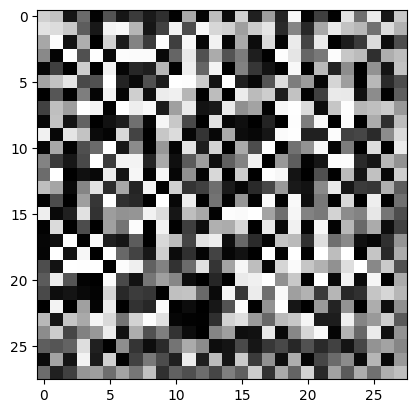

In [115]:
import torch

generator = Generator()

noise = torch.randn([1, 100])
# noise = noise.unsqueeze(0).unsqueeze(0)
generated_image = generator(noise)
gen_im = torch.Tensor.detach(generated_image).numpy()
plt.imshow(gen_im[0, 0, :, :], cmap='gray')

discriminator = Discriminator(28)

print(discriminator(generated_image))

In [119]:
from torch import optim

bce_loss = nn.BCEWithLogitsLoss()

def gen_loss(output):
  return bce_loss(torch.ones_like(output), output)

def disc_loss(real, fake):
  real_loss = bce_loss(torch.ones_like(real), real)
  fake_loss = bce_loss(torch.zeros_like(fake), fake)
  return real_loss + fake_loss

gen_opt = optim.Adam(generator.parameters(), lr = 0.0001)
disc_opt = optim.Adam(discriminator.parameters(), lr = 0.0001)
BATCH_SIZE = 32
noise_dim = 100
epochs = 50

train_im = []


for e in range(epochs):
  generated_images = generator()

  real_output = discriminator(train_im)
  fake_output = discriminator(generated_images)

  gen_l = gen_loss(fake_output)
  disc_l = disc_loss(real_output, fake_output)

  gen_l.backward()
  gen_opt.step()
  disc_l.backward()
  disc_opt.step()



TypeError: Adam.__init__() missing 1 required positional argument: 'params'